# Modeling the Model

Lets see exactly where we end up with the most/least error

In [1]:
import os

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, trim_mean

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.models.eval import predict_values
from optpresso.data.partition import find_test_paths

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error

from keras.models import load_model

from IPython.core.display import display

In [29]:
# Because GPUs aren't that much faster for inference
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
plt.rcParams["figure.dpi"] = 150
# For better accuracy use a validation/test set
DATA_DIR = os.path.expanduser("~/partition/test")

model = load_model(os.path.expanduser("~/proj/optpresso/partition-v8-stride-tons-more-filters.h5"), compile=False)

loader = GroundsLoader(256, (model.input_shape[1], model.input_shape[2]), directory=DATA_DIR)

In [30]:
paths, y_true, y_pred = predict_values(model, loader)

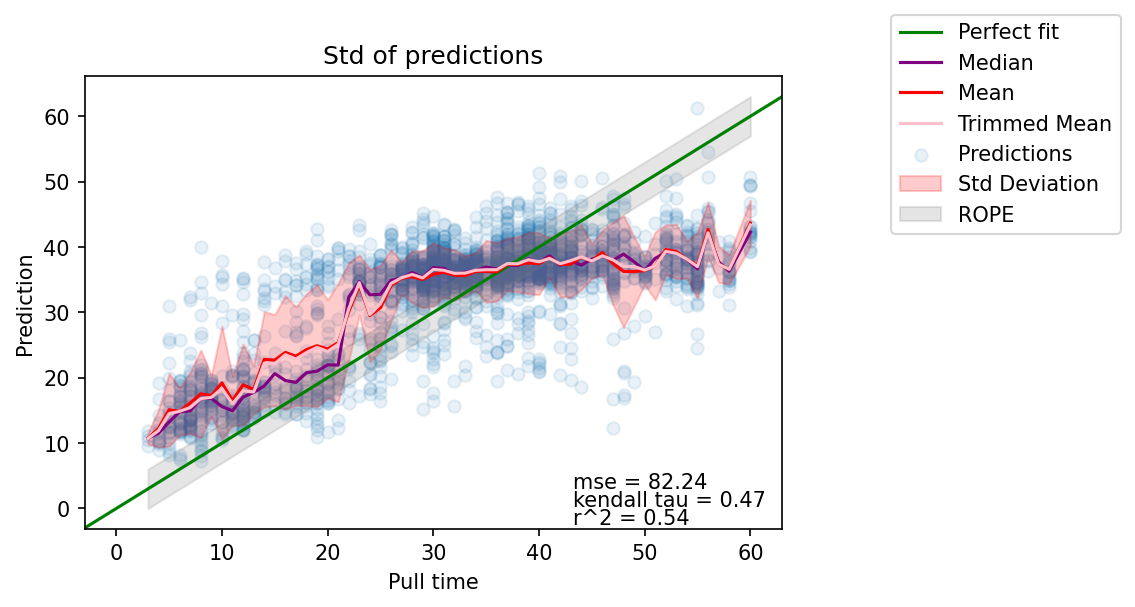

In [31]:
bins = defaultdict(list)
for real, pred in zip(y_true, y_pred):
    bins[real].append(pred)
x = np.zeros(len(bins))
y = np.zeros_like(x)
meds = np.zeros_like(x)
trimmed_mean = np.zeros_like(x)
deviations = np.zeros_like(x)
areas_missed_by_std = np.zeros(len(bins), dtype=np.bool)
for i, (time, predictions) in enumerate(sorted(bins.items(), key=lambda x: x[0])):
    x[i] = time
    y[i] = np.mean(predictions)
    meds[i] = np.median(predictions)
    trimmed_mean[i] = trim_mean(predictions, proportiontocut=0.1)
    deviations[i] = np.std(predictions)
    areas_missed_by_std[i] = deviations[i] < abs(y[i] - time)
fig, ax = plt.subplots(dpi=150)
ax.axline([0, 0], [1, 1], color="g", label="Perfect fit")
ax.scatter(y_true, y_pred, alpha=.1, label="Predictions")
ax.plot(x, meds, color="purple", label="Median")
ax.plot(x, y, color="red", label="Mean")
ax.plot(x, trimmed_mean, color="pink", label="Trimmed Mean")
ax.fill_between(x, (y-deviations), (y+deviations), color='r', alpha=.2, label="Std Deviation")
ax.fill_between(x, (x-3), (x+3), color='gray', alpha=.2, label="ROPE")
ax.set_ylabel("Prediction")
ax.set_xlabel("Pull time")
ax.set_title("Std of predictions")
fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.annotate(
    "kendall tau = {:.2f}".format(kendalltau(y_true, y_pred)[0]),
    (0.7, 0.05),
    xycoords="axes fraction",
)
ax.annotate(
    "r^2 = {:.2f}".format(r2_score(y_true, y_pred)),
    (0.7, 0.01),
    xycoords="axes fraction",
)
plt.annotate(
    "mse = {:.2f}".format(mean_squared_error(y_true, y_pred)),
    (0.7, 0.09),
    xycoords="axes fraction",
)

plt.show()

### Areas where 1 standard deviation from mean did not include the actual time

This is not great since it may not be actually normally distributed, but its mildly helpful as a way to indicate where more data could help improve the model.

In [32]:
hit_rate = 0.0
for x, missed in zip(x, areas_missed_by_std):
    if missed:256
        print(f"Need more data for: {x}")
    else:
        hit_rate += 1.0
hit_rate = hit_rate / len(bins)
print(f"Percentage within range: {hit_rate}")

Need more data for: 3.0
Need more data for: 4.0
Need more data for: 5.0
Need more data for: 6.0
Need more data for: 7.0
Need more data for: 8.0
Need more data for: 9.0
Need more data for: 10.0
Need more data for: 11.0
Need more data for: 12.0
Need more data for: 13.0
Need more data for: 14.0
Need more data for: 15.0
Need more data for: 22.0
Need more data for: 23.0
Need more data for: 26.0
Need more data for: 27.0
Need more data for: 28.0
Need more data for: 29.0
Need more data for: 30.0
Need more data for: 31.0
Need more data for: 43.0
Need more data for: 44.0
Need more data for: 45.0
Need more data for: 46.0
Need more data for: 47.0
Need more data for: 48.0
Need more data for: 49.0
Need more data for: 50.0
Need more data for: 51.0
Need more data for: 52.0
Need more data for: 53.0
Need more data for: 54.0
Need more data for: 55.0
Need more data for: 56.0
Need more data for: 57.0
Need more data for: 58.0
Need more data for: 60.0
Percentage within range: 0.3333333333333333


In [33]:
stacked_data = np.dstack((paths, y_true, y_pred))
stacked_data.resize(len(paths), 3)
sort = np.argsort(stacked_data[:,1])
sorted_data = stacked_data[sort]

### Investigate the inability to distinguish between 30s and 50s shots

A problem I have noticed is that the model has issues learning the difference between a 30 second shot and a 50 second shot. This investigated the point at which that distinction has the biggest impact on the MSE/MAD.

The following two cells look at cutting off from low to high (cut off at 10 seconds, then 15, etc) then high to low (cut off 60 seconds, then 55, etc) to see the impact of on the statistics.

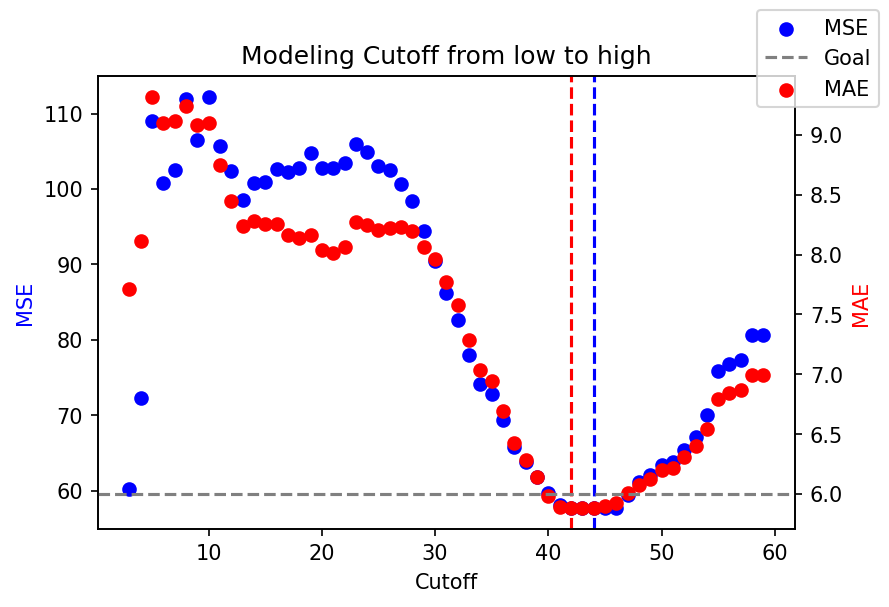

Low Cutoff with lowest MSE (44.0, 57.649564973627974)
Low Cutoff with lowest MAE (42.0, 5.878238891130234)


In [34]:
mse_data = []
mad_data = []
x = np.arange(min(sorted_data[:, 1]), max(sorted_data[:, 1]), 1)
min_mse_cutoff = None
min_mad_cutoff = None
for cutoff in x:
    idx = 0
    for i in range(len(paths)):
        if sorted_data[i][1] > cutoff:
            idx = i
            break
    trimmed_x = sorted_data[:,1][:idx]
    trimmed_y = sorted_data[:,2][:idx]
    if not len(trimmed_x):
        continue
    mse_data.append(mean_squared_error(trimmed_x, trimmed_y))
    mad_data.append(mean_absolute_error(trimmed_x, trimmed_y))
    if min_mse_cutoff is None or mse_data[-1] < min_mse_cutoff[1]:
        min_mse_cutoff = (cutoff, mse_data[-1])
    if min_mad_cutoff is None or mad_data[-1] < min_mad_cutoff[1]:
        min_mad_cutoff = (cutoff, mad_data[-1])
fig, axe = plt.subplots(dpi=150)
axe.scatter(x, mse_data, label="MSE", color="blue")
axe.set_xlabel("Cutoff")
axe.set_ylabel("MSE", color="blue")
axe.axvline(min_mse_cutoff[0], color="blue", linestyle="--")
axe_2 = axe.twinx()
axe_2.scatter(x, mad_data, label="MAE", color="red")
axe_2.set_ylabel("MAE", color="red")
axe_2.axvline(min_mad_cutoff[0], color="red", linestyle="--")
axe_2.axhline(6, color="gray", linestyle="dashed", label="Goal")
axe.set_title("Modeling Cutoff from low to high")
fig.legend()
plt.show()
print("Low Cutoff with lowest MSE", min_mse_cutoff)
print("Low Cutoff with lowest MAE", min_mad_cutoff)

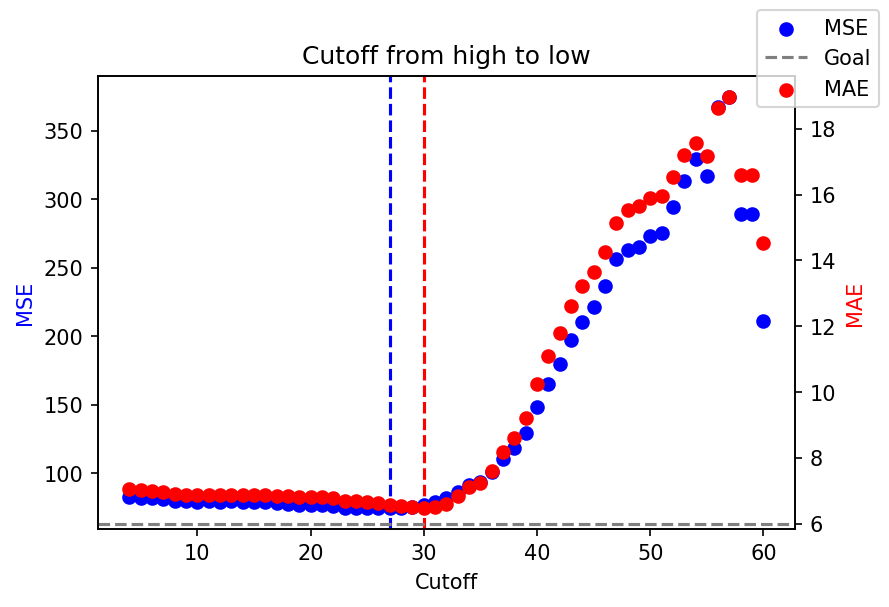

High Cutoff with lowest MSE (27.0, 74.27278179522392)
High Cutoff with lowest MAE (30.0, 6.459096671116014)


In [35]:
mse_data = []
mad_data = []
x = np.arange(max(sorted_data[:, 1]), min(sorted_data[:, 1]), -1)
min_mse_cutoff = None
min_mad_cutoff = None
for cutoff in x:
    idx = 0
    for i in reversed(range(len(paths))):
        if sorted_data[i][1] <= cutoff:
            idx = i
            break
    trimmed_x = sorted_data[:,1][idx:]
    trimmed_y = sorted_data[:,2][idx:]
    if not len(trimmed_x):
        continue
    mse_data.append(mean_squared_error(trimmed_x, trimmed_y))
    mad_data.append(mean_absolute_error(trimmed_x, trimmed_y))
    if min_mse_cutoff is None or mse_data[-1] < min_mse_cutoff[1]:
        min_mse_cutoff = (cutoff, mse_data[-1])
    if min_mad_cutoff is None or mad_data[-1] < min_mad_cutoff[1]:
        min_mad_cutoff = (cutoff, mad_data[-1])
fig, axe = plt.subplots(dpi=150)
axe.scatter(x, mse_data, label="MSE", color="blue")
axe.set_xlabel("Cutoff")
axe.set_ylabel("MSE", color="blue")
axe.axvline(min_mse_cutoff[0], color="blue", linestyle="--")
axe_2 = axe.twinx()
axe_2.scatter(x, mad_data, label="MAE", color="red")
axe_2.set_ylabel("MAE", color="red")
axe_2.axvline(min_mad_cutoff[0], color="red", linestyle="--")
axe_2.axhline(6, color="gray", linestyle="dashed", label="Goal")
axe.set_title("Cutoff from high to low")
fig.legend()
plt.show()
print("High Cutoff with lowest MSE", min_mse_cutoff)
print("High Cutoff with lowest MAE", min_mad_cutoff)

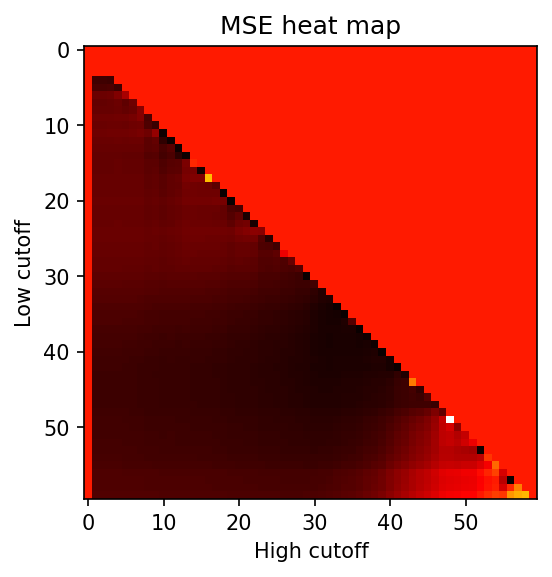

Cutoff with lowest MSE (33.0, 34.0, 0.10714094439754263)


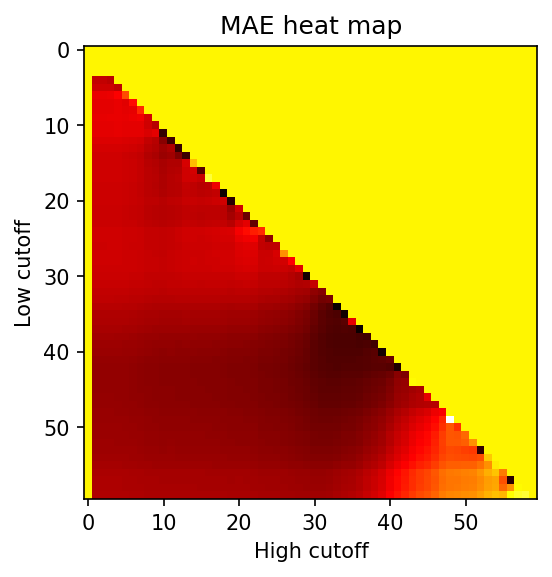

Cutoff with lowest MAE (33.0, 34.0, 0.32732391357421875)


In [36]:
x = np.arange(0, max(sorted_data[:, 1]), 1)
y = np.arange(max(sorted_data[:, 1]) - 1, 0, -1)
mse_data = np.ones((len(x), len(x))) * 300
mad_data = np.ones_like(mse_data) * 20
min_mse_cutoff = None
min_mad_cutoff = None
for high_cutoff in x:
    for low_cutoff in y:
        if low_cutoff >= high_cutoff:
            continue
        high_idx = 0
        for i in range(len(paths)):
            if sorted_data[i][1] >= high_cutoff:
                high_idx = i
                break
        low_idx = 0
        for i in reversed(range(len(paths))):
            if sorted_data[i][1] <= low_cutoff:
                low_idx = i
                break
        trimmed_x = sorted_data[:,1][low_idx:high_idx]
        trimmed_y = sorted_data[:,2][low_idx:high_idx]
        if not len(trimmed_x):
            continue
        mse = mean_squared_error(trimmed_x, trimmed_y)
        mae = mean_absolute_error(trimmed_x, trimmed_y)
        mse_data[int(high_cutoff), int(low_cutoff)] = mse
        mad_data[int(high_cutoff), int(low_cutoff)] = mae
        if min_mse_cutoff is None or mse < min_mse_cutoff[2]:
            min_mse_cutoff = (low_cutoff, high_cutoff, mse)
        if min_mad_cutoff is None or mae < min_mad_cutoff[2]:
            min_mad_cutoff = (low_cutoff, high_cutoff, mae)
plt.imshow(mse_data, cmap="hot", interpolation="nearest")
plt.xlabel("High cutoff")
plt.ylabel("Low cutoff")
plt.title("MSE heat map")
plt.show()
print("Cutoff with lowest MSE", min_mse_cutoff)


plt.imshow(mad_data, cmap="hot", interpolation="nearest")
plt.xlabel("High cutoff")
plt.ylabel("Low cutoff")
plt.title("MAE heat map")
plt.show()
print("Cutoff with lowest MAE", min_mad_cutoff)